# 군집분석

In [1]:
from clustering_models_copy import service_type_sep, make_scaled_df, num_of_components, feature_explained_variance,\
                            scree_plot, elbow_method, k_distance_plot, clustering_model, cluster_evaluation, comparison_of_scores_kmeans,\
                            cluster_visualization, cluster_separation, clusters_center, compare_columns, cluster_center_visualize, visualize_service_type, get_dbscan_parameter_score
from data_preparation import get_data, get_cluster_df, get_regression_df
from EDA import box_plt, skew_kurt_graph

from itertools import product

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="/Users/leeseohyun/Library/Fonts/AppleGothic.ttf").get_name()
mpl.rc('font', family=font_name)
plt.rcParams["axes.unicode_minus"] = False

## 데이터 불러오기

In [ ]:
# AWS EC2 인스턴스에서 MySQL DB 생성
# pymysql 라이브러리를 활용하여 MySQL에 연결하고 데이터베이스에 적재하고 table을 가져오는 방식으로 진행  
# 현재 AWS 인스턴스가 존재하지 않는(종료된) 상태이므로 csv파일을 불러오는 코드를 추가함

''' 
cnx = pymysql.connect(user='mt-1', password='1111', host='ec2-15-152-249-56.ap-northeast-3.compute.amazonaws.com', database='zigbang_project')

query = 'SELECT * FROM zigbang_project.zb_final;'

df = pd.read_sql(query, cnx)

cnx.close()
'''

# 전처리된 데이터 불러오기 
''' 
cnx = pymysql.connect(user='mt-1', password='1111', host='ec2-15-152-249-56.ap-northeast-3.compute.amazonaws.com', database='zigbang_project')
query = 'SELECT * FROM zigbang_project.zb_final_cluster;'
df = pd.read_sql(query, cnx)
cnx.close()
'''

In [2]:
# 군집분석에 맞는 전처리된 데이터 불러오기 
clustering_df = get_cluster_df() 

## EDA

In [ ]:
# 이상치 확인
box_plt(clustering_df)

In [ ]:
# 데이터 분포 확인
# 왜도 > 2, 첨도 > 3 인 피쳐의 분포 확인
temp_col = skew_kurt_graph(clustering_df)

## 군집 모델링 기법 선정 과정

In [3]:
# 스케일된 데이터 생성
# scaling : MinMax, Standard, Robust 
standard_df, minmax_df, robust_df, df_ohe = make_scaled_df(clustering_df)

In [39]:
# 차원축소를 위한 주성분 개수 후보 선정
num_of_components(clustering_df)

# 후보 주성분 개수 
# (누적기여율 70~80%)
# Unscaled : 2 / Standard : 16, 17, 18, 19 / MinMax : 9, 10, 11 / Robust : 7, 8, 9, 10

Data Unscaled
                고윳값           기여율     누적기여율
pca1   1.218533e+08  9.084107e-01  0.908411
pca2   1.010003e+07  7.529520e-02  0.983706
pca3   1.196845e+06  8.922420e-03  0.992628
pca4   6.455681e+05  4.812679e-03  0.997441
pca5   1.470252e+05  1.096066e-03  0.998537
pca6   1.114195e+05  8.306267e-04  0.999368
pca7   7.495253e+04  5.587675e-04  0.999926
pca8   7.512217e+03  5.600322e-05  0.999982
pca9   2.134593e+03  1.591329e-05  0.999998
pca10  1.723338e+02  1.284740e-06  1.000000
pca11  3.875831e+01  2.889413e-07  1.000000
pca12  7.175764e+00  5.349497e-08  1.000000
pca13  1.401829e+00  1.045057e-08  1.000000
pca14  1.201345e+00  8.955966e-09  1.000000
pca15  4.874981e-01  3.634275e-09  1.000000
pca16  3.808085e-01  2.838909e-09  1.000000
pca17  2.260656e-01  1.685308e-09  1.000000
pca18  2.196185e-01  1.637245e-09  1.000000
pca19  1.612430e-01  1.202059e-09  1.000000
pca20  1.323853e-01  9.869261e-10  1.000000
pca21  1.265655e-01  9.435399e-10  1.000000
pca22  1.152850e-0

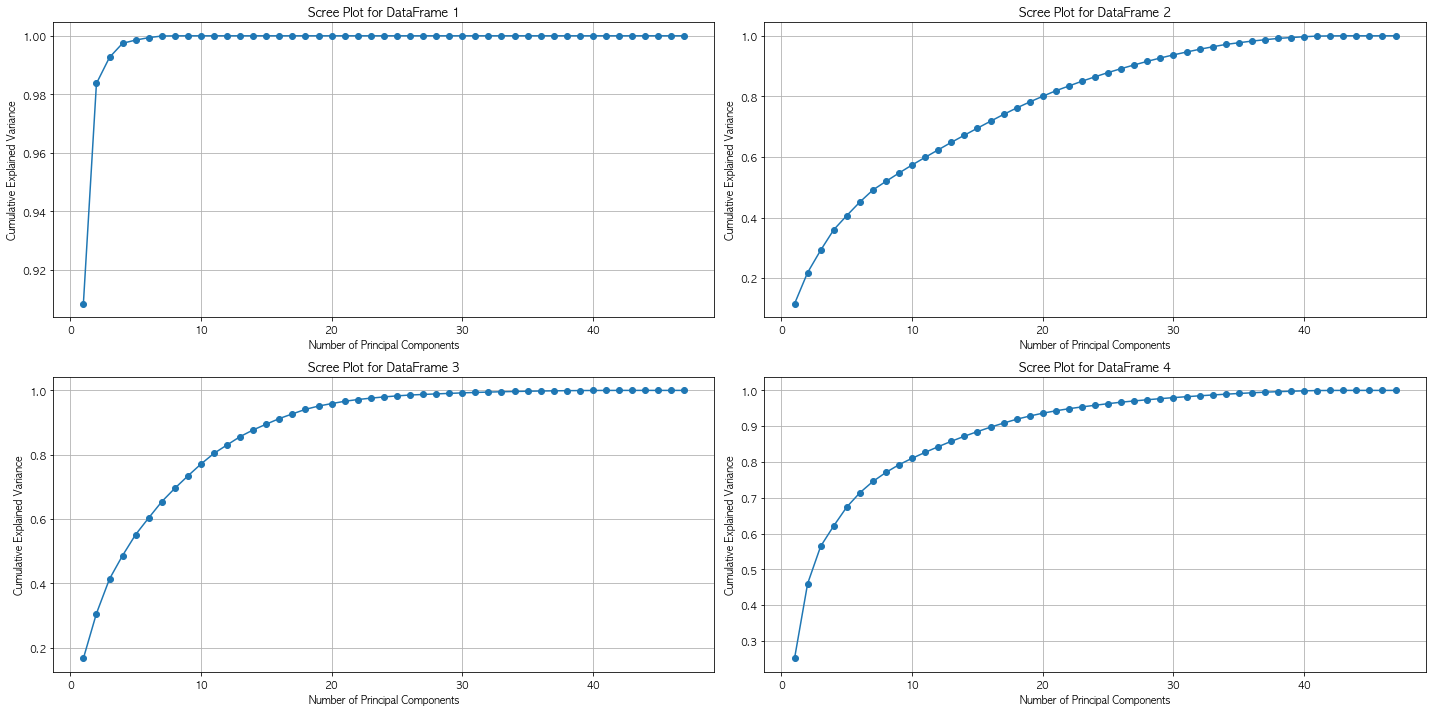

In [41]:
scree_plot(clustering_df)

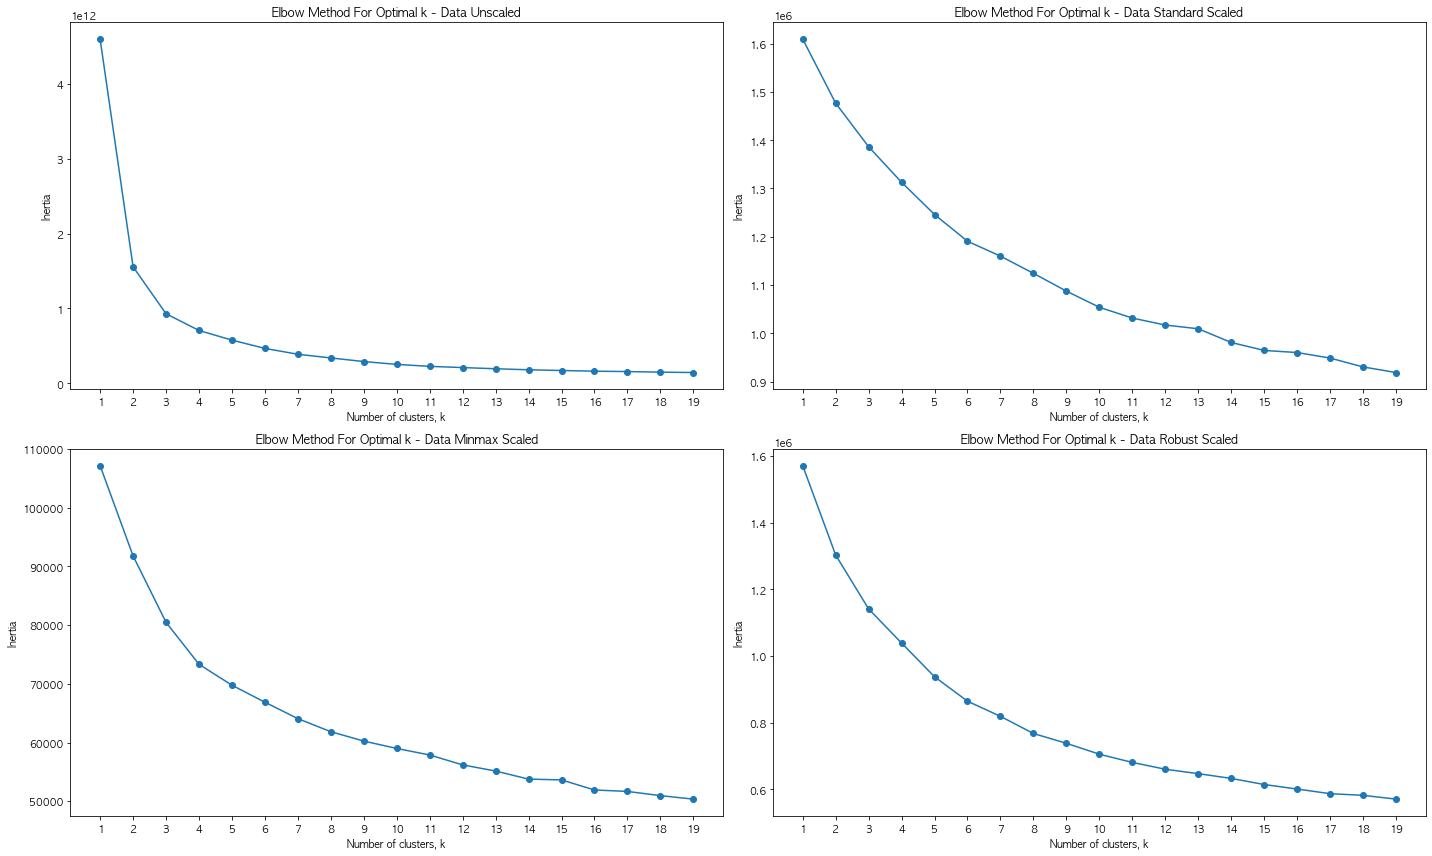

In [40]:
# 군집 개수 후보 선정
elbow_method(clustering_df)

# 후보 군집 개수 
# Unscaled : 2, 3, 4, 5 / Standard : 5, 6, 7, 8 / MinMax : 3, 4, 5, 6 / Robust : 3, 4, 5, 6

### 1) KMeans

 1)  모델에 적용될 파라미터들을 조합해보고 실루엣 계수를 구해보기

 2)  각 스케일러별 점수가 좋은 파라미터 조합을 선택하고 모델에 적용하여 시각화해보기

 3)  3차원 시각화 결과를 통해 군집별로 데이터가 고르게 분포되었는지 확인 (군집간 거리가 적절하게 떨어져있는지 등을 시각적으로 확인하고자함)

In [ ]:
'''
Args:
        dataframe (pd.DataFrame): 입력 데이터프레임
        method (str) : 군집 알고리즘('KMeans', 'DBSCAN', 'MeanShift')
        scaling_method (str): 스케일링 방법('standard', 'minmax', 'robust', 'unscaled')
        dim_reduction_method (str): 차원 축소 방법('PCA', 'TruncatedSVD')
        n_components (int): 차원 축소 후의 컴포넌트 개수
        n_clusters (int): 클러스터의 개수 in KMeans
        eps (int) : epsilon in DBSCAN
'''

In [6]:
# 실루엣 계수 비교

params = {
    'method': ['KMeans'],
    'scaling_method': ['minmax'], #['unscaled'], 'standard', 'minmax', 'robust']
    'dim_reduction_method' : ['PCA', 'TruncatedSVD'],
    'n_components': [9, 10, 11],  # [2],[16, 17, 18, 19], [9, 10, 11], [7, 8, 9, 10]]
    'n_clusters': [3, 4, 5, 6] #[2, 3, 4, 5], [5, 6, 7, 8], [3, 4, 5, 6], [3, 4, 5, 6]]
}

param_combinations = product(*params.values())

comparison_of_scores_kmeans(clustering_df, param_combinations, params)

method: KMeans, scaling_method: minmax, n_components: 9, n_clusters: 3, silhouette_avg: 0.2607376446086308
method: KMeans, scaling_method: minmax, n_components: 9, n_clusters: 4, silhouette_avg: 0.24818516202722776
method: KMeans, scaling_method: minmax, n_components: 9, n_clusters: 5, silhouette_avg: 0.22275997457316526
method: KMeans, scaling_method: minmax, n_components: 9, n_clusters: 6, silhouette_avg: 0.23684785260418736
method: KMeans, scaling_method: minmax, n_components: 10, n_clusters: 3, silhouette_avg: 0.2470964224913749
method: KMeans, scaling_method: minmax, n_components: 10, n_clusters: 4, silhouette_avg: 0.23335684738288354
method: KMeans, scaling_method: minmax, n_components: 10, n_clusters: 5, silhouette_avg: 0.20793062242840146
method: KMeans, scaling_method: minmax, n_components: 10, n_clusters: 6, silhouette_avg: 0.20142135045615064
method: KMeans, scaling_method: minmax, n_components: 11, n_clusters: 3, silhouette_avg: 0.23670352950749984
method: KMeans, scaling_m

최종 스케일링 기법 선정

In [ ]:
# Unscaled
# cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'unscaled', dim_reduction_method='PCA', n_components = 2, n_clusters = 3)
# cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'unscaled', dim_reduction_method='TruncatedSVD', n_components = 2, n_clusters = 4)
# Standard
# cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'standard', dim_reduction_method='PCA', n_components = 2, n_clusters = 3)
# cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'standard', dim_reduction_method='TruncatedSVD', n_components = 2, n_clusters = 4)
# Robust
# cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'Robust', dim_reduction_method='PCA', n_components = 2, n_clusters = 3)
# cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'Robust', dim_reduction_method='TruncatedSVD', n_components = 2, n_clusters = 4)

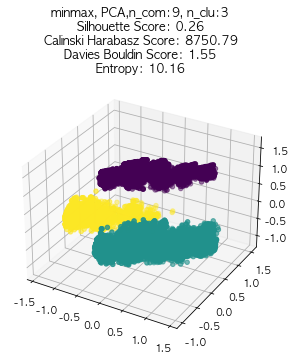

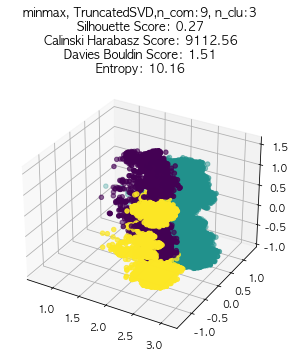

In [4]:
# MinMax
cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 9, n_clusters = 3)
cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 9, n_clusters = 3)

# MinMax Scaler 최종 선택 

차원축소 기법 선정

In [ ]:
# n_components = 9 일때
# TruncatedSVD의 실루엣 계수는 높지만 시각화 결과 PCA를 이용해 차원을 축소한 데이터로 적합한 모델에서 군집이 더 잘 나뉜 것으로 보임

최종 군집 개수 선정

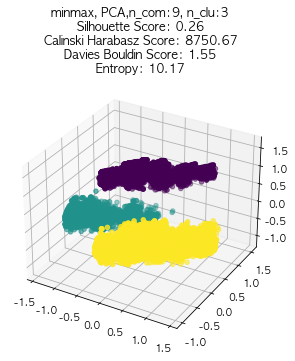

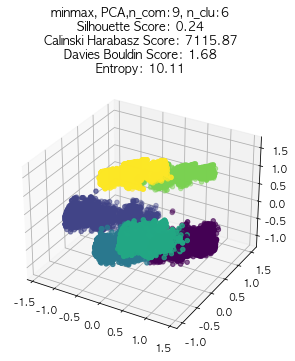

In [5]:
cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 9, n_clusters = 3)
cluster_visualization(clustering_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 9, n_clusters = 6)


KMeans 최종 모델

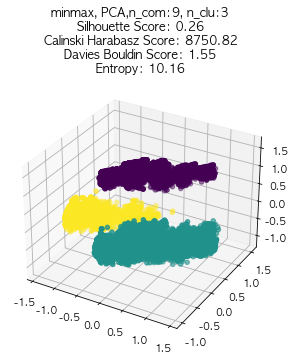

In [6]:
params = {
    'method': "KMeans",
    'scaling_method': "minmax",
    'dim_reduction_method': "PCA",
    'n_components': 9,
    'n_clusters': 3
}

cluster_visualization(clustering_df, **params)

### 2) DBSCAN

In [ ]:
# params = {
#     'method': "DBSCAN",
#     'scaling_method': "minmax",
#     'dim_reduction_method': "PCA",
#     'n_components': 3,
#     'eps':9,
#     'min_samples':10
# }

# cluster_visualization(clustering_df, **params)

### 3) MeanShift

In [ ]:
# params = {
#     'method': "MeanShift",
#     'scaling_method': "minmax",
#     'dim_reduction_method': "PCA",
#     'n_components': 3
# }

# cluster_visualization(clustering_df, **params)

군집 모델링 기법 : KMeans

## 군집 중심점 분석

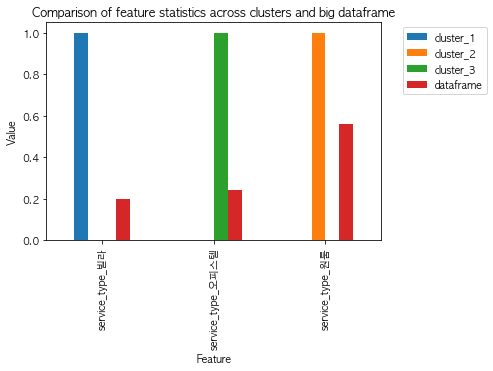

In [4]:
# 군집 특징 파악위해 각 군집의 중심점을 변수별로 시각화
params = {
    'method': "KMeans",
    'scaling_method': "minmax",
    'dim_reduction_method': "PCA",
    'n_components': 9,
    'n_clusters': 3
}

visualize_service_type(clustering_df, **params)

#주택 유형별(service_type 변수)로 3개의 군집이 형성됨 (원룸, 빌라, 오피스텔)

# 군집 모델링 발전
- service_type이 아닌 다른 변수의 특성을 반영한 군집을 보여주기 위해 service_type별로 클러스터링 진행
- 원 데이터에서 KMeans의 성능이 좋았기 때문에 분할 후 데이터에도 KMeans 군집 알고리즘을 우선 적용해보기로함

In [3]:
# service_type별 데이터프레임 생성하기
villa_drop_df, oneroom_drop_df, officetel_drop_df = service_type_sep(clustering_df)

### 1) 원룸

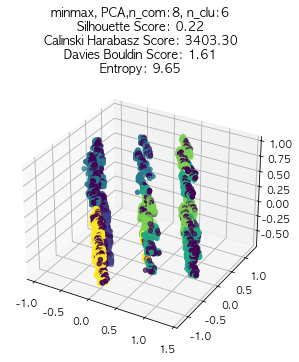

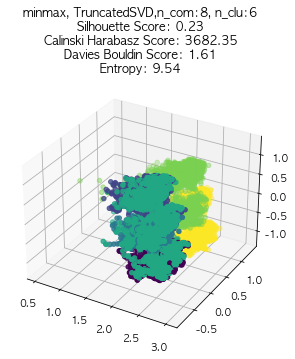

In [6]:
cluster_visualization(oneroom_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 8, n_clusters = 6)
cluster_visualization(oneroom_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 8, n_clusters = 6)

### 2) 빌라

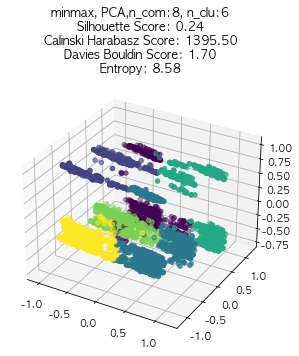

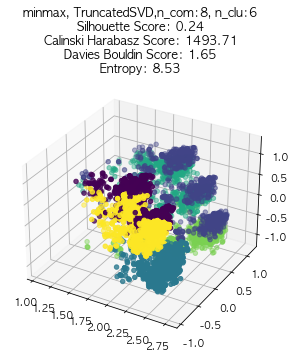

In [7]:
cluster_visualization(villa_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 8, n_clusters = 6)
cluster_visualization(villa_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 8, n_clusters = 6)

### 3) 오피스텔

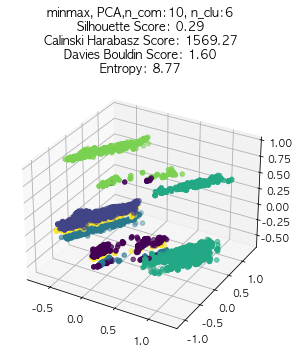

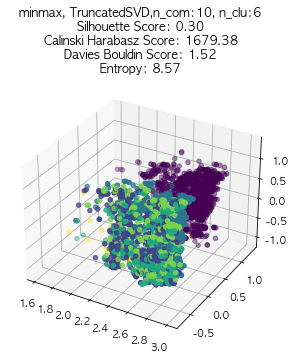

In [8]:
cluster_visualization(officetel_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='PCA', n_components = 10, n_clusters = 6)
cluster_visualization(officetel_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 10, n_clusters = 6)

In [ ]:
# 차원축소 기법 TruncatedSVD 에서 실루엣 계수가 더 높아 해당 기법을 선택하기로함
# n_components가 8, 10 으로 너무 커서 3차원 시각화로 군집이 잘 나뉘었는지 정확히 확인하기 어려움 

## 주성분 특성 파악
- 군집의 특성을 파악하기 위해 차원축소 후의 주성분 특성을 파악하는 과정을 거침
- 각 주성분을 설명하는 변수를 파악하면 군집의 특성도 파악할 수 있지 않을까?

In [10]:
# 데이터의 수가 가장 많은 원룸 데이터를 예시로 변수별 주성분 요소 값을 계산
feature_explained_variance(oneroom_drop_df, scaling_method='minmax', n_components=8, dim_reduction_method='TruncatedSVD')


Component 1:
sales_type_월세: 0.3916
hhd_private_p: 0.3861
ppltn_adult_p: 0.3417
parking: 0.2693
options_count: 0.257
aging: 0.2542
building_apt_p: 0.2247
elevator: 0.2064
hhd_alone_p: 0.2019
hhd_family_p: 0.1974
manage_cost_count: 0.1852
safety_idx: 0.1727
near_subways_count: 0.1461
building_dasedae_p: 0.1346
ppltn_dnsty: 0.1304
aged: 0.1187
room_direction_text_남향: 0.1103
gender_ratio: 0.0971
room_direction_text_동향: 0.0799
building_dandok_p: 0.0689
room_direction_text_남서향: 0.0621
public_institution_dist: 0.0594
hospital_dist: 0.0511
cultural_venue_dist: 0.0505
room_direction_text_서향: 0.0505
school_dist: 0.0502
building_nonresidential_p: 0.049
rent_adjusted: 0.0489
room_direction_text_남동향: 0.0465
building_others_p: 0.0428
supermarket_dist: 0.0391
_floor: 0.0376
size_m2: 0.0372
hhd_collective_p: 0.0358
convenience_store_dist: 0.0333
sales_type_전세: 0.0291
room_direction_text_북향: 0.0269
room_direction_text_북동향: 0.0246
building_yeonlip_p: 0.0244
subway_dist: 0.0232
room_direction_text_북서향: 0

In [11]:
# 각 주성분을 설명하는 변수가 다른 주성분과 차별점이 있도록 차원의 개수를 줄여나감
# -> 차원의 개수를 4개로 했을 때 차별점이 생긴 것을 확인

feature_explained_variance(oneroom_drop_df, scaling_method='minmax', n_components=4, dim_reduction_method='TruncatedSVD')


Component 1:
sales_type_월세: 0.3916
hhd_private_p: 0.3861
ppltn_adult_p: 0.3417
parking: 0.2693
options_count: 0.257
aging: 0.2542
building_apt_p: 0.2247
elevator: 0.2064
hhd_alone_p: 0.2019
hhd_family_p: 0.1974
manage_cost_count: 0.1852
safety_idx: 0.1727
near_subways_count: 0.1461
building_dasedae_p: 0.1346
ppltn_dnsty: 0.1304
aged: 0.1187
room_direction_text_남향: 0.1103
gender_ratio: 0.0971
room_direction_text_동향: 0.0799
building_dandok_p: 0.0689
room_direction_text_남서향: 0.0621
public_institution_dist: 0.0594
hospital_dist: 0.0511
cultural_venue_dist: 0.0505
room_direction_text_서향: 0.0505
school_dist: 0.0502
building_nonresidential_p: 0.049
rent_adjusted: 0.0489
room_direction_text_남동향: 0.0465
building_others_p: 0.0428
supermarket_dist: 0.0391
_floor: 0.0376
size_m2: 0.0372
hhd_collective_p: 0.0358
convenience_store_dist: 0.0333
sales_type_전세: 0.0291
room_direction_text_북향: 0.0269
room_direction_text_북동향: 0.0246
building_yeonlip_p: 0.0244
subway_dist: 0.0232
room_direction_text_북서향: 0

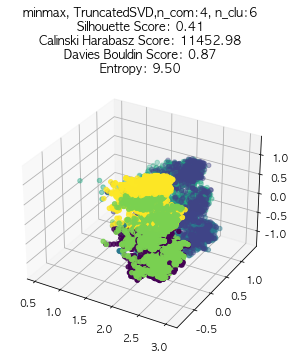

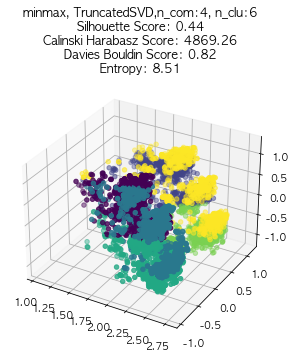

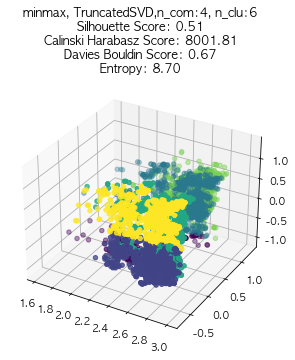

In [12]:
# 차원개수 줄인 후 결과 시각화
cluster_visualization(oneroom_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 4, n_clusters = 6)
cluster_visualization(villa_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 4, n_clusters = 6)
cluster_visualization(officetel_drop_df, method = 'KMeans', scaling_method = 'minmax', dim_reduction_method='TruncatedSVD', n_components = 4, n_clusters = 6)

# 시각화 결과 또는 실루엣 점수를 확인해봤을 때 n_components = 4로 설정했을때 성능이 개선됨을 확인

## 군집 특성 파악
- 군집 별 중심점 시각화

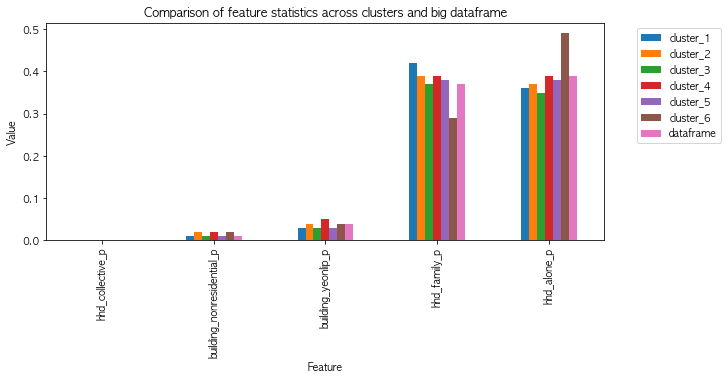

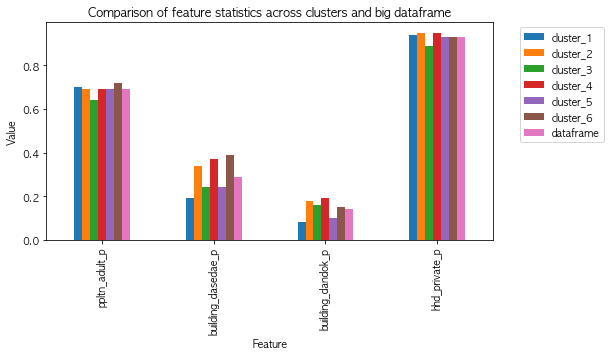

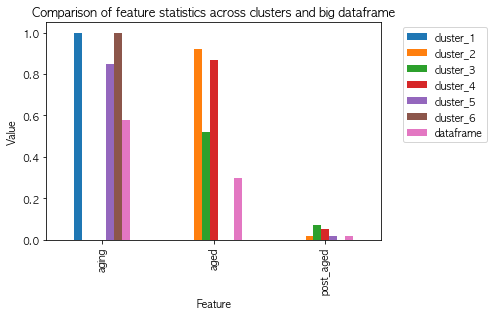

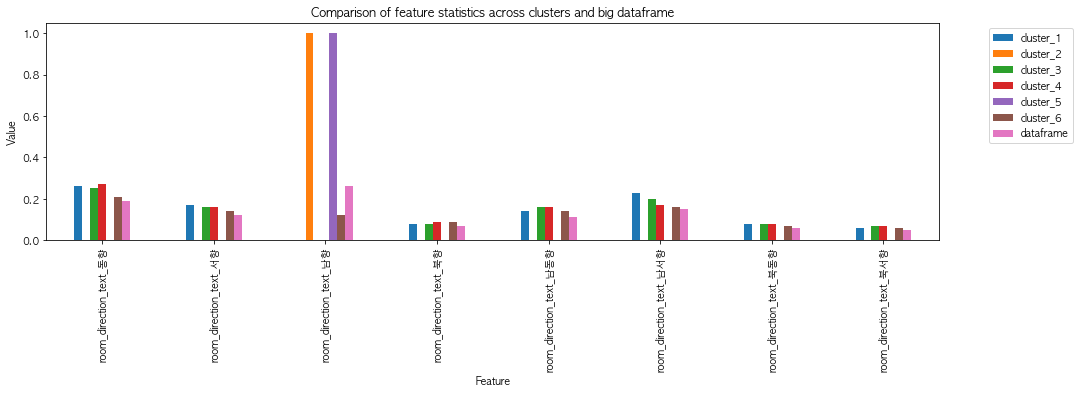

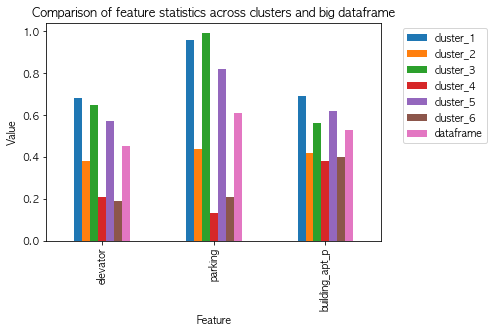

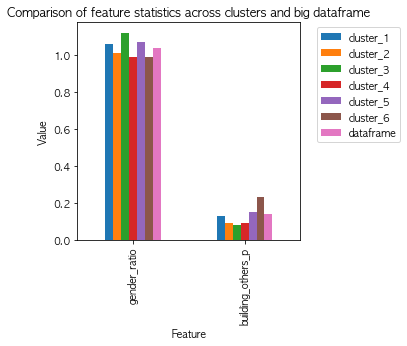

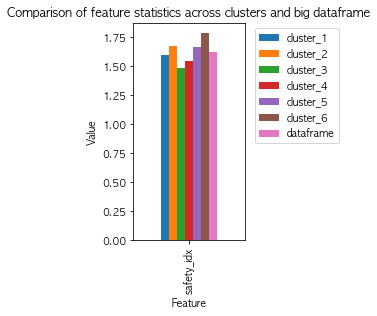

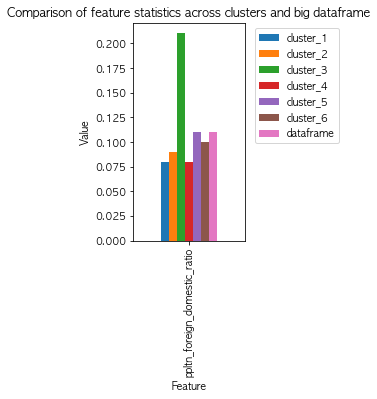

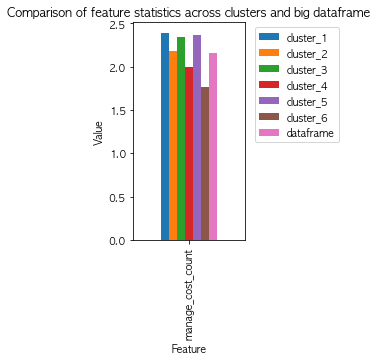

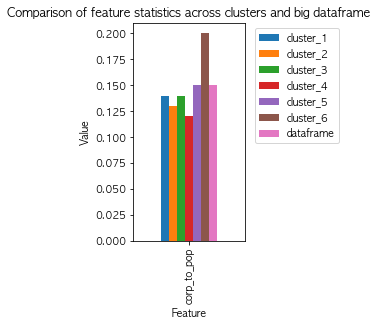

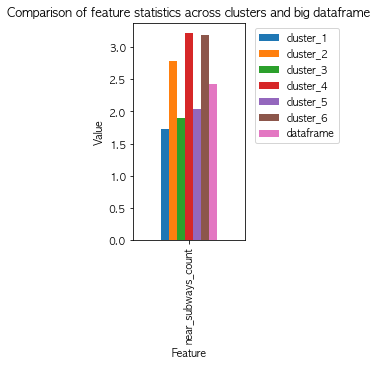

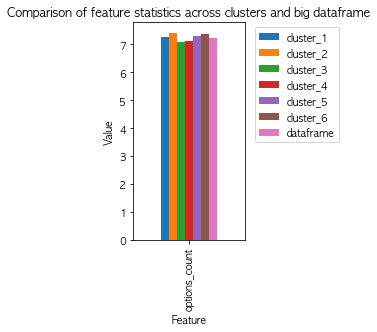

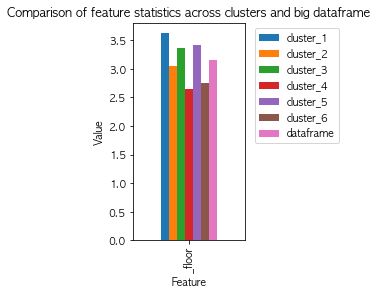

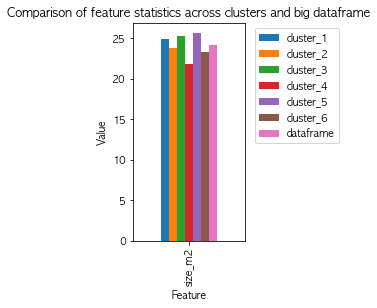

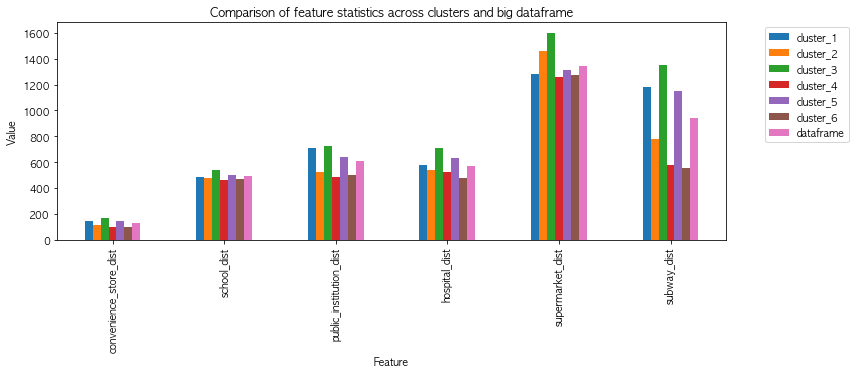

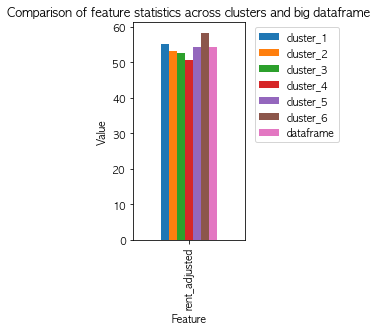

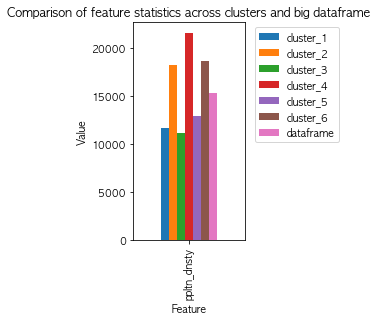

In [4]:
params = {
    'method': "KMeans",
    'scaling_method': "minmax",
    'dim_reduction_method': "TruncatedSVD",
    'n_components': 4,
    'n_clusters': 6
}

cluster_center_visualize(oneroom_drop_df, **params)
# cluster_center_visualize(villa_drop_df, **params)
# cluster_center_visualize(officetel_drop_df, **params)
